In [1]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

In [2]:
def integration_indexes(x, a, b):
    idx_a = np.argmin(np.abs(x - a))
    idx_b = np.argmin(np.abs(x - b))
    return idx_a, idx_b

In [3]:
def phase_change(f, d):
    return 4 * np.pi * f * d / sc.c

In [58]:
def trapezoid_signal(t, ramp_up, ramp_down, high, low):
    samples = len(t)
    total_time = ramp_up + ramp_down + high + low
    if total_time != 1 :
        raise ValueError("Total time must be 1")
    signal = np.zeros_like(t)

    ramp_up_samples = int(ramp_up * samples)
    ramp_down_samples = int(ramp_down * samples)
    high_samples = int(high * samples)
    low_samples = int(low * samples)
    
    signal[:ramp_up_samples] = np.linspace(0, 1, ramp_up_samples)
    signal[ramp_up_samples:ramp_up_samples + high_samples] = 1
    signal[ramp_up_samples + high_samples:-low_samples] = np.linspace(1, 0, ramp_down_samples)
    signal[-low_samples:] = 0
    
    return signal

In [4]:
def get_signals(t, f, d, I0=0.5, I1=0.5, E=0, M=0):
    """
    t ... time
    f ... frequency
    d ... distance
    I0 ... transmision signal intensity
    I1 ... reflection signal intensity

    returns:
    T ... Transmision signal
    R ... Reflection signal
    M_0 ... 0 phase modulation signal 
    M_1 ... 90 phase modulation signal
    M_2 ... 180 phase modulation signal
    M_3 ... 270 phase modulation signal
    """
    
    T = I0 * np.sin(2 * np.pi * f * t) + E

    R = I1 * np.sin(2 * np.pi * f * t - phase_change(f, d)) + E

    M_0 = np.sin(2 * np.pi * f * t) + M
    M_1 = np.sin(2 * np.pi * f * t - np.pi / 2) + M
    M_2 = np.sin(2 * np.pi * f * t - np.pi) + M
    M_3 = np.sin(2 * np.pi * f * t - 3 * np.pi / 2) + M

    return T, R, M_0, M_1, M_2, M_3

In [98]:
def get_trapezoid_signals(t, f, d, I0=0.5, I1=0.5, E=2, M=2):
    """
    t ... time
    f ... frequency
    d ... distance
    I0 ... transmision signal intensity
    I1 ... reflection signal intensity

    returns:
    T ... Transmision signal
    R ... Reflection signal
    M_0 ... 0 phase modulation signal 
    M_1 ... 90 phase modulation signal
    M_2 ... 180 phase modulation signal
    M_3 ... 270 phase modulation signal
    """

    
    T = I0 * trapezoid_signal(t, ramp_up, ramp_down, high, low) + E

    R = I1 * np.roll(trapezoid_signal(t, ramp_up, ramp_down, high, low), int(phase_change(f, d) / 2 / np.pi * len(t))) + E

    M_0 = trapezoid_signal(t, ramp_up, ramp_down, high, low) + M
    M_1 = np.roll(M_0, int(len(t) / 4))
    M_2 = np.roll(M_0, int(len(t) / 2))
    M_3 = np.roll(M_0, int(3 * len(t) / 4))

    return T, R, M_0, M_1, M_2, M_3

In [70]:
def simulate(set_d=None, part=1):
    """
    This function simulates the IToF system at the provided distance `set_d` or globally set variable `d`.
    """
    
    if (set_d != None):
        d_ = set_d
    else:
        d_ = d

    # Signals    
    if part == 1 or part == 2:
        _, s_r, s_m00, s_m90, sm180, sm270 = get_signals(t, f, d_, I0, I1)
    elif part == 3:
        _, s_r, s_m00, s_m90, sm180, sm270 = get_trapezoid_signals(t, f, d_, I0, I1)

    # Integration
    s_m00r = s_m00 * s_r
    s_m90r = s_m90 * s_r
    s_m180r = sm180 * s_r
    s_m270r = sm270 * s_r

    n = 100
    T_int = n * tp

    a, b = integration_indexes(t, 0, T_int)
    s_m00r_int = np.trapz(s_m00r[a:b], t[a:b])
    s_m90r_int = np.trapz(s_m90r[a:b], t[a:b]) 
    if part == 2 or part == 3:
        s_m180r_int = np.trapz(s_m180r[a:b], t[a:b])
        s_m270r_int = np.trapz(s_m270r[a:b], t[a:b])

    # Results
    if part == 1:
        pc_calc = np.arctan2(s_m90r_int, s_m00r_int)
    elif part == 2 or part == 3:
        pc_calc = np.arctan2(s_m90r_int - s_m270r_int, s_m00r_int - s_m180r_int)

    d_calc = pc_calc * sc.c / (4 * np.pi * f)

    if pc_calc < 0:
        pc_calc += 2 * np.pi
    
    if d_calc < 0:
        d_calc += sc.c / f / 2

    return pc_calc, d_calc

In [87]:
def plot_signals(sim=False, part=1):
    if part == 1 or part == 2:
        s_t, s_r, s_m_0, s_m_90, s_m_180, s_m_270 = get_signals(t, f, d, I0, I1, M=0 if part == 1 else 2, E=0 if part == 1 else 2)
    if part == 3:
        s_t, s_r, s_m_0, s_m_90, s_m_180, s_m_270 = get_trapezoid_signals(t, f, d, I0, I1, M=2, E=2)
    s_rs = s_r * s_m_0 
    s_r90s = s_r * s_m_90
    s_r180s = s_r * s_m_180
    s_r270s = s_r * s_m_270
    lim = 100


    plt.figure(figsize=(12, 8))

    plt.subplot(2,2,1) if not sim else plt.subplot(2,4,(1,2))
    plt.title("Transmited and modulation signals")
    plt.plot(t_ns, s_m_0, label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns, s_m_90, label="90 phase modulated signal", color="orange")
    plt.plot(t_ns, s_t, label="Transmitted signal", color="#2444ca", linewidth=3)
    plt.xlim(0, lim)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    plt.subplot(2,2,2) if not sim else plt.subplot(2,4,(3,4))
    plt.title("Reflected and modulation signals")
    plt.plot(t_ns, s_m_0, label="0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns, s_m_90, label="90 phase modulated signal", color="#55797a")
    if part == 2 or part == 3:
        plt.plot(t_ns, s_m_180, label="180 phase modulated signal", color="#55595a")
        plt.plot(t_ns, s_m_270, label="270 phase modulated signal", color="#55292a")
    plt.plot(t_ns, s_r, label="Reflected signal", color="#ca2444", linewidth=3)
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.xlim(0, lim)
    plt.grid()
    plt.legend()

    plt.subplot(2,1,2) if not sim else plt.subplot(2,4,(5,7))
    plt.xlim(0, lim)
    plt.title("Product of reflected and modulation signals")
    plt.plot(t_ns, s_rs, label="Reflected and 0 phase modulated signal", color="#55a9aa")
    plt.plot(t_ns, s_r90s, label="Reflected and 90 phase modulated signal", color="orange")
    if part == 2 or part == 3:
        plt.plot(t_ns, s_r180s, label="Reflected and 180 phase modulated signal", color="#55797a")
        plt.plot(t_ns, s_r270s, label="Reflected and 270 phase modulated signal", color="#55595a")
    plt.xlabel("Time [ns]")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()

    if sim:
        ds = np.array([(*simulate(d, part), d) for d in np.arange(0, wl/2-1 if part == 3 else wl, wl / 100)])

        plt.subplot(248)
        plt.title("Phase change and distance")
        plt.plot(ds[:, 2], ds[:, 0], label="Distance", color="#55a9aa")
        plt.ylabel("Phase change [rad]")
        plt.xlabel("Distance [m]")
        plt.grid()

    plt.tight_layout()

    plt.show()

In [78]:
t = np.arange(0, 1e-7, 1e-12) # time [s] (1e-7 = 100 ns)
t_ns = t * 1e9

# Laser parameters
f = 1e7 # frequency [Hz]
I0 = 0.5 # transmision signal intensity

# Calculated parameters
wl = sc.c / f # wavelength [m]
tp = 1 / f    # period [s]

print("Laser Parameters:")
print(" - Frequency: {:.2f} MHz".format(f*1e-6))
print(" - Wavelength: {:.2f} m".format(wl))
print(" - Period: {:.2f} ns".format(tp*1e9))

Laser Parameters:
 - Frequency: 10.00 MHz
 - Wavelength: 29.98 m
 - Period: 100.00 ns


In [106]:
# Case parameters
I1 = 0.5 # reflection signal intensity
d = 3 # distance [m]
pc = phase_change(f, d) # phase change [rad]

pc_calc, d_calc = simulate()

print(f"{'':>20} | {'expected':>10} | {'calculated':>10} |")
print(f"{'Distance [m]':>20} | {d:10.2f} | {d_calc:10.2f} |")
print(f"{'Phase change [rad]':>20} | {pc:10.2f} | {pc_calc:10.2f} |")

                     |   expected | calculated |
        Distance [m] |       3.00 |       3.00 |
  Phase change [rad] |       1.26 |       1.26 |


# Part 1

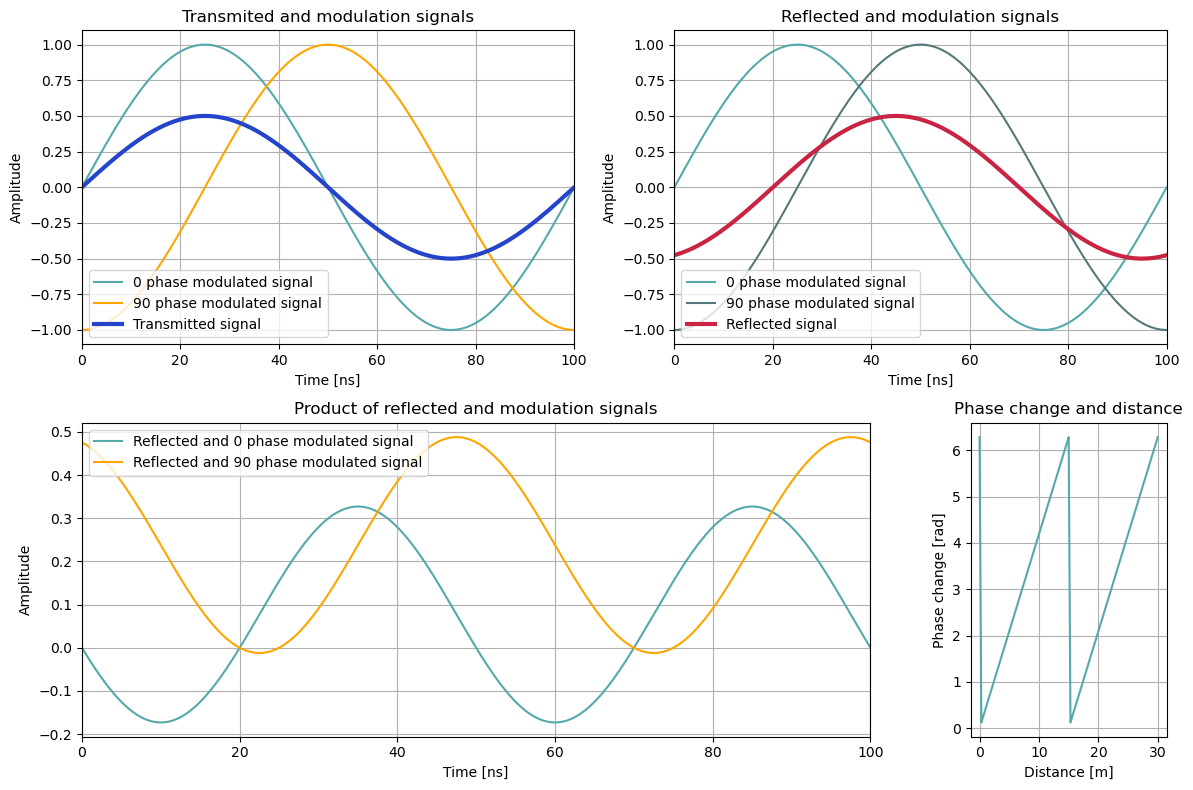

In [107]:
plot_signals(sim=True)

On the graph that shows phase change over distance of the object we can see that phase change is $\varphi=2\pi$ when the object is at $1/2$ of the wavelength away from the sensor. This is because the wave has to travel to and from the object so the distance that the wave travels is twice as long as the distance from the sensor to the object.

# Part 2

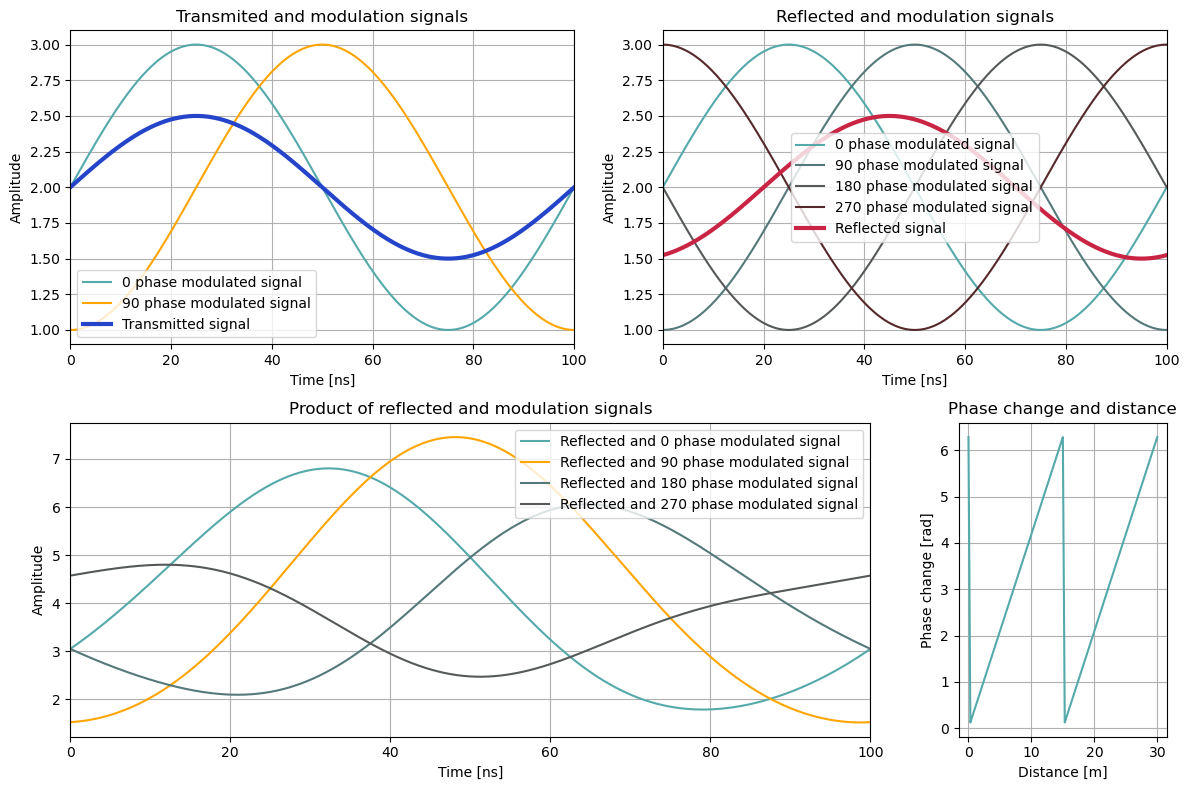

In [108]:
plot_signals(sim=True, part=2)

# Part 3

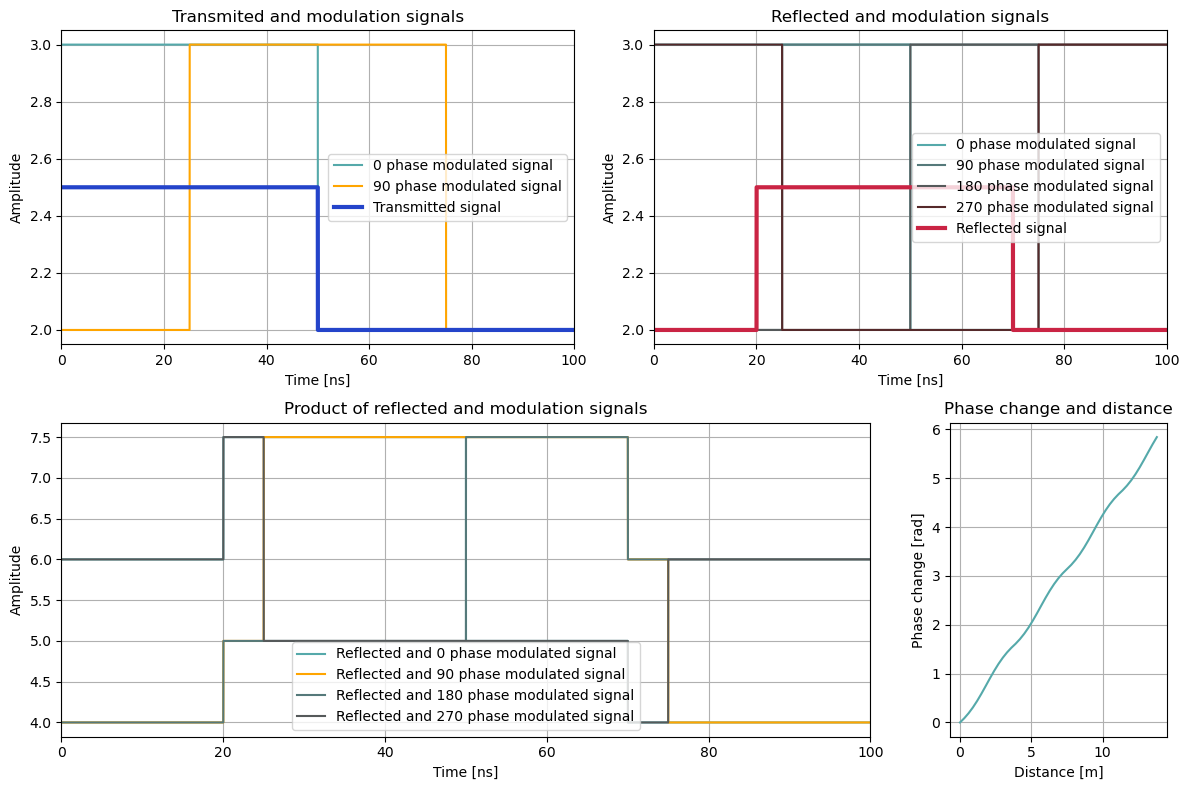

In [109]:
ramp_up = 0
ramp_down = 0
high = 0.5
low = 0.5

plot_signals(sim=True, part=3)

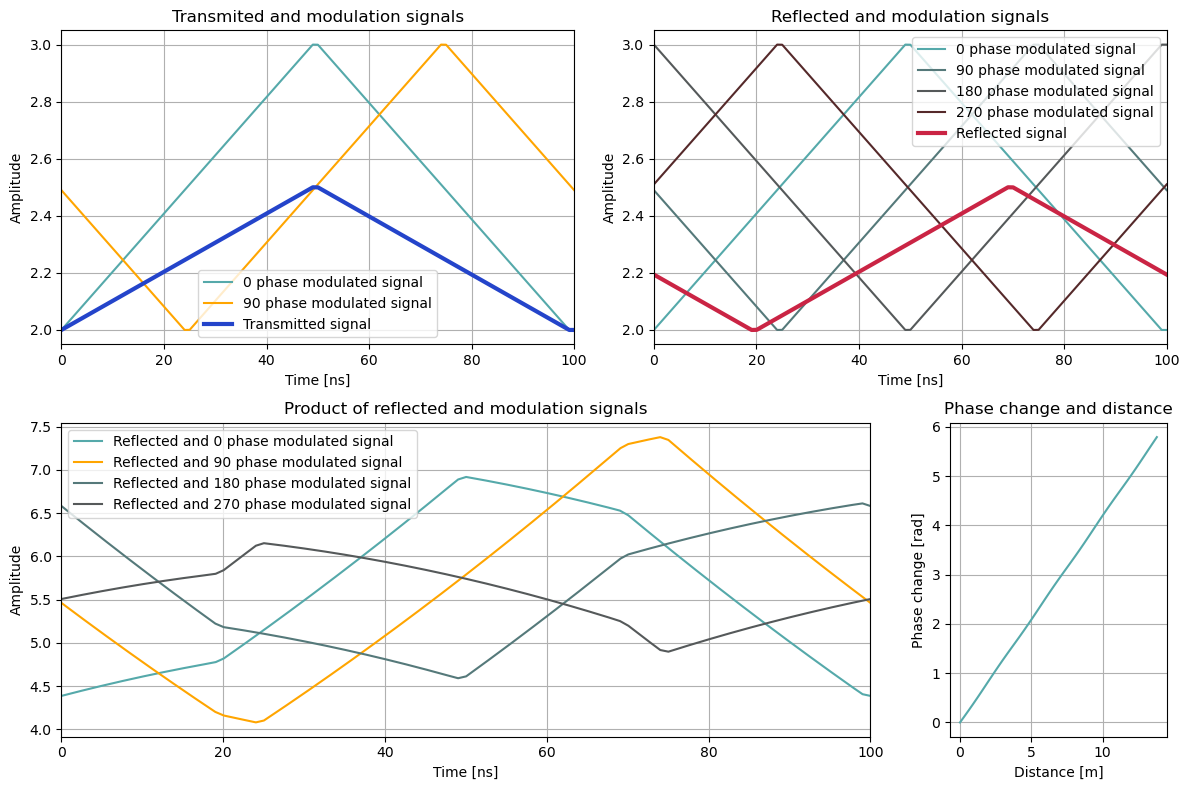

In [110]:
ramp_up = 0.49
ramp_down = 0.49
high = 0.01
low = 0.01

plot_signals(sim=True, part=3)

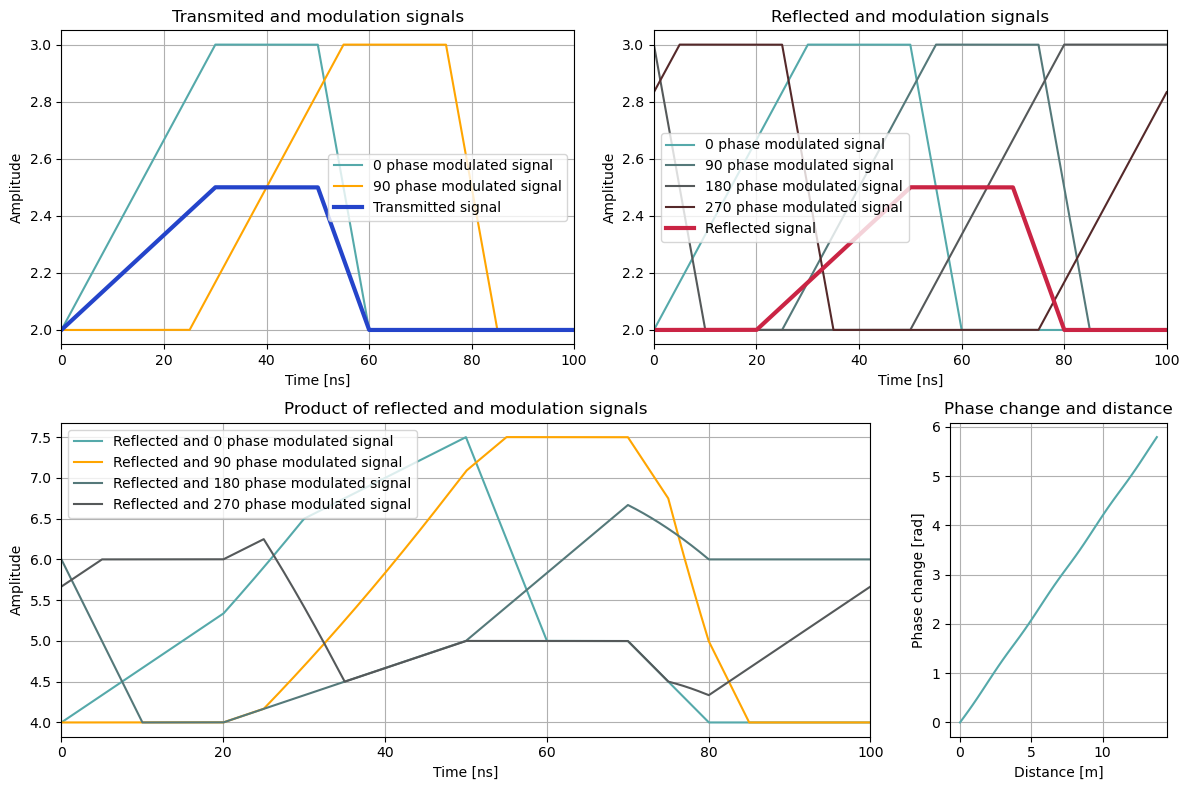

In [111]:
ramp_up = 0.3
ramp_down = 0.1
high = 0.2
low = 0.4

plot_signals(sim=True, part=3)